# 0 - Imports python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from langdetect import detect, DetectorFactory
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from scikeras.wrappers import KerasClassifier
from sklearn.utils.class_weight import compute_class_weight


# 1 - Import des fichiers train.csv et test.csv

In [2]:
train_path = "./assets/train.csv"
train = pd.read_csv(train_path)

test_path = "./assets/test.csv"
test = pd.read_csv(test_path)

In [3]:
train.head()

,Labels,Text,Text_Tag
0,1,Says the Annies List political group supports ...,abortion
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments"
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy
3,1,Health care reform legislation is likely to ma...,health-care
4,2,The economic turnaround started at the end of ...,"economy,jobs"


In [4]:
test.head()

,Text,Text_Tag
0,Building a wall on the U.S.-Mexico border will...,immigration
1,Wisconsin is on pace to double the number of l...,jobs
2,Says John McCain has done nothing to help the ...,"military,veterans,voting-record"
3,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti..."
4,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti..."


# 2 - Traitement des données train

## 1 - Analyse des données

In [5]:
label = "Labels"

print(train[label].unique())

[1 2 3 5 0 4]


In [6]:
print("Valeurs Labels manquantes :", train[label].isna().sum())

Valeurs Labels manquantes : 0


In [7]:
tag = "Text_Tag"
print(list(train[tag].unique()))

['abortion', 'energy,history,job-accomplishments', 'foreign-policy', 'health-care', 'economy,jobs', 'education', 'candidates-biography', 'ethics', 'jobs', 'energy,message-machine-2014,voting-record', 'elections', 'economy,jobs,new-hampshire-2012,poverty', 'history,state-budget', 'economy,federal-budget,health-care', 'federal-budget', 'financial-regulation,foreign-policy,water', 'bankruptcy,economy,population', 'economy,income', 'corporations,taxes', 'economy', 'health-care,message-machine', 'abortion,federal-budget,health-care', 'crime,diversity,homeland-security,terrorism', 'technology,terrorism', 'diversity,economy,jobs', 'candidates-biography,elections,campaign-advertising', 'economy,labor,states,unions,workers', 'climate-change,energy,environment,government-regulation', 'small-business,taxes', 'bipartisanship,voting-record', 'consumer-safety,corrections-and-updates,government-regulation,market-regulation,states,supreme-court,workers', 'city-government,population', 'military', 'heal

In [8]:
print("Valeurs Text_Tag manquantes :", train[tag].isna().sum())

Valeurs Text_Tag manquantes : 2


- Remplacement des null par "unknown"

In [9]:
train[tag] = train[tag].fillna("unknown")

In [10]:
text = "Text"
print("Valeurs Text manquantes :", train[text].isna().sum())

Valeurs Text manquantes : 0


### Analyse du champs Text

In [11]:
doublons = train[text].duplicated().sum()
print(doublons)

17


In [12]:
len_text = "len_text"
word_text = "word_text"

train[len_text] = train[text].str.len()
train[word_text] = train[text].str.split().str.len()

print(train[[len_text, word_text]].describe())

           len_text     word_text
count  10240.000000  10240.000000
mean     106.918750     18.010059
std       59.917722      9.658572
min       11.000000      2.000000
25%       73.000000     12.000000
50%       99.000000     17.000000
75%      132.250000     22.000000
max     3192.000000    467.000000


In [13]:
def repeated_letters(text):
    return bool(re.search(r"([a-zA-Z])\1{2,}", str(text)))

repeated_letters_column = "repeated_letters"

train[repeated_letters_column] = train[text].apply(repeated_letters)

print(train[repeated_letters_column].value_counts())

repeated_letters
False    10232
True         8
Name: count, dtype: int64


In [14]:
train[train[repeated_letters_column] == True].head(8)

,Labels,Text,Text_Tag,len_text,word_text,repeated_letters
1353,1,Says Wisconsin state Senate President Michael ...,"elections,states",127,20,True
5094,2,Under Mayor Angel Taveras Providences bond rat...,"city-budget,job-accomplishments",113,18,True
5610,2,Black people kill more black people every six ...,"crime,history",82,16,True
6823,0,President Obama and Democrats spending addicti...,federal-budget,214,34,True
7995,5,"Says that unlike Texas, Missouri has a perfect...","economy,state-budget,state-finances,states",65,11,True
8320,1,Florida was the only state during my eight yea...,state-finances,89,19,True
9064,0,Trump refuses to denounce the KKK.,candidates-biography,34,6,True
9660,2,Rhode Island is the last state still using the...,elections,123,21,True


- Malgré la répétition des lettres, je constate que le texte reste "réel"

### Aide à la décision sur longueur du champs Text

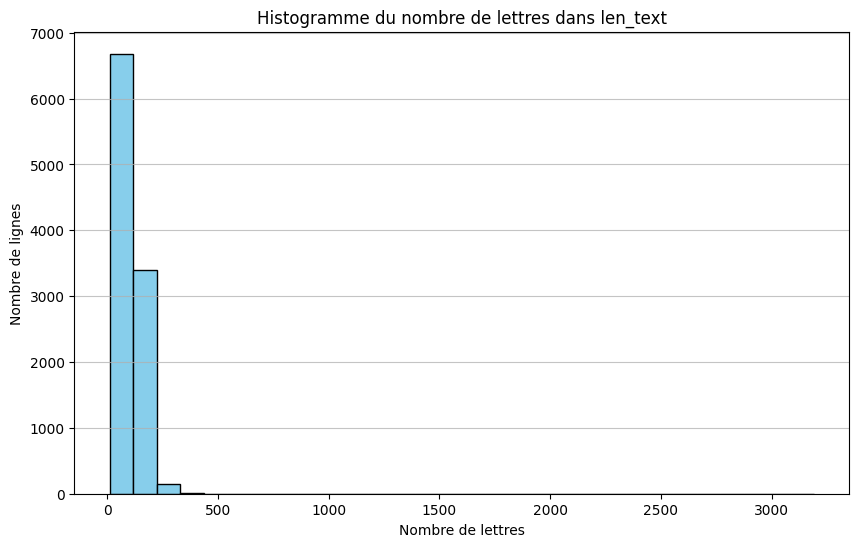

In [15]:
# Répartition du nombre de lettres
plt.figure(figsize=(10,6))
plt.hist(train[len_text], bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Nombre de lettres")
plt.ylabel("Nombre de lignes")
plt.title("Histogramme du nombre de lettres dans len_text")
plt.grid(axis='y', alpha=0.75)
plt.show()


In [16]:
# Moyenne et médiane
mean_len = train[len_text].mean()
median_len = train[len_text].median()
print("\nMoyenne :", mean_len)
print("Médiane :", median_len)

# Quartiles 25% et 75%
q25 = train[len_text].quantile(0.25)
q75 = train[len_text].quantile(0.75)
print("25% :", q25)
print("75% :", q75)

# Percentiles de 80% à 95% par pas de 5%
percentiles = train[len_text].quantile([0.8, 0.85, 0.9, 0.95])
print("\nPercentiles 80% à 95% :")
print(percentiles)


Moyenne : 106.91875
Médiane : 99.0
25% : 73.0
75% : 132.25

Percentiles 80% à 95% :
0.80    142.0
0.85    153.0
0.90    167.0
0.95    191.0
Name: len_text, dtype: float64


- Je prends la décision de rester en dessous de 200 caractères afin de limiter surtout les textes exotiques dépassant les 500 caratères.

### Décompte du nombre de tag par text

In [17]:
train["count_tag"] = train[tag].str.count(",") + 1
train.head()

,Labels,Text,Text_Tag,len_text,word_text,repeated_letters,count_tag
0,1,Says the Annies List political group supports ...,abortion,82,11,False,1
1,2,When did the decline of coal start? It started...,"energy,history,job-accomplishments",141,24,False,3
2,3,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,105,19,False,1
3,1,Health care reform legislation is likely to ma...,health-care,78,12,False,1
4,2,The economic turnaround started at the end of ...,"economy,jobs",54,10,False,2


### Répartition suivant nombre de tags

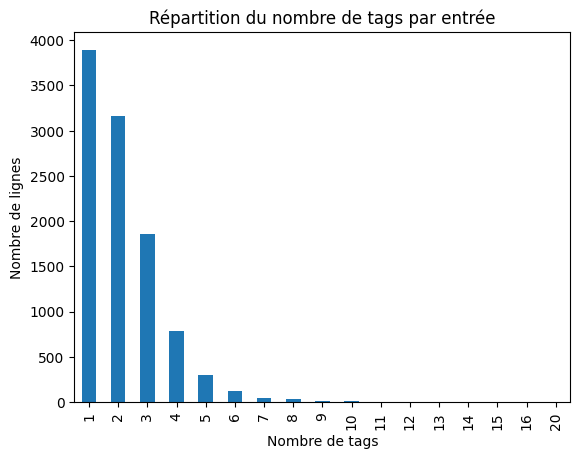

In [18]:
repartition = train["count_tag"].value_counts().sort_index()
repartition.plot(kind="bar")
plt.xlabel("Nombre de tags")
plt.ylabel("Nombre de lignes")
plt.title("Répartition du nombre de tags par entrée")
plt.show()

In [19]:
mean = train["count_tag"].mean()

median = train["count_tag"].median()

q25 = train["count_tag"].quantile(0.25)
q75 = train["count_tag"].quantile(0.75)
q85 = train["count_tag"].quantile(0.85)
q95 = train["count_tag"].quantile(0.95)


print("Moyenne :", mean)
print("Médiane :", median)
print("25% :", q25)
print("75% :", q75)
print("85% :", q85)
print("95% :", q95)


Moyenne : 2.16845703125
Médiane : 2.0
25% : 1.0
75% : 3.0
85% : 3.0
95% : 5.0


- On pourrait limiter le nombre de tags à 3 sans perte de beaucoup d'informations dans nos données, à voir.


### Pré-nettoyage des données train

In [20]:
train[text] = train[text].str.lower()
train[tag] = train[tag].str.lower()

In [21]:
train[text] = train[text].str.strip()
train[tag] = train[tag].str.strip()

In [22]:
train[tag] = train[tag].str.replace(","," ")

In [23]:
all_tags = train[tag].str.split().explode()

In [24]:
tag_counts = all_tags.value_counts()

In [25]:
print("20 tags les plus fréquents :")
print(tag_counts.head(20))

20 tags les plus fréquents :
Text_Tag
economy                 1162
health-care             1128
taxes                    994
federal-budget           744
education                728
jobs                     711
state-budget             696
candidates-biography     653
elections                607
immigration              532
foreign-policy           471
crime                    446
history                  405
energy                   382
legal-issues             344
environment              336
guns                     330
military                 315
workers                  293
job-accomplishments      293
Name: count, dtype: int64


In [26]:
print("\n20 tags les moins fréquents :")
print(tag_counts.tail(20))


20 tags les moins fréquents :
Text_Tag
disability              21
ebola                   20
florida-amendments      16
baseball                15
occupy-wall-street      14
space                   12
sotomayor-nomination    11
kagan-nomination        10
natural-disasters        8
10-news-tampa-bay        5
fake-news                5
lottery                  4
autism                   3
colbert-report           3
unknown                  2
food                     2
after-the-fact           2
death-penalty            2
homeless                 1
fires                    1
Name: count, dtype: int64


### Suppression des tags rares (<= 5 apparitions)

In [27]:
seuil = 5

def remove_rare_tag(tag_string):
    tags = tag_string.split()
    tags_kept = [t for t in tags if tag_counts[t] > seuil]
    return " ".join(tags_kept)

train[tag] = train[tag].apply(remove_rare_tag)

print(train[train[tag].str.contains(r"\bhomeless\b", na=False)]) # test sur le tag homeless qui comptait 1 apparition

Empty DataFrame
Columns: [Labels, Text, Text_Tag, len_text, word_text, repeated_letters, count_tag]
Index: []


- Vérification de la non-création de tag "null"

In [28]:
print(train[tag].isna().sum())

0


## 2 - Nettoyage des données train

### 0 - Roadmap

Suite à l'analyse précédente j'applique les actions suivantes :
- Limitation des tags à 3 (les plus représentés) sur la colonne "Text_Tag"
- Limitation à 200 caractères sur la colonne "Text"
- Concernant les labels :
    - Exclure les inconnues
    - Regrouper les labels
    - Ordonner logiquement les labels
    - Vérifier la représentation des classes
    - Réajuster si nécessaire

### 1 - Limitation des tags

In [29]:
def top_tags(tag_string, n=3):
    tags = tag_string.split()
    tags_sorted = sorted(tags, key=lambda t: tag_counts[t], reverse=True)
    return " ".join(tags_sorted[:n])

train[tag] = train[tag].apply(top_tags)
train.head()

,Labels,Text,Text_Tag,len_text,word_text,repeated_letters,count_tag
0,1,says the annies list political group supports ...,abortion,82,11,False,1
1,2,when did the decline of coal start? it started...,history energy job-accomplishments,141,24,False,3
2,3,"hillary clinton agrees with john mccain ""by vo...",foreign-policy,105,19,False,1
3,1,health care reform legislation is likely to ma...,health-care,78,12,False,1
4,2,the economic turnaround started at the end of ...,economy jobs,54,10,False,2


### 2 - Limitation du nombre de caractères de Text

#### Détection de langue

In [30]:
DetectorFactory.seed = 0 

def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

train["lang"] = train[text].astype(str).apply(detect_language)


In [31]:
lang = "lang"

train[lang].value_counts()

lang
en    10146
fr       18
da       13
ca       12
it       11
af        6
es        5
id        5
et        5
tl        4
nl        4
no        3
sv        3
cy        2
pt        1
de        1
so        1
Name: count, dtype: int64

Suppression des autres langues que EN :

In [32]:
train = train[train["lang"] == "en"].copy()

In [33]:
nltk.download("stopwords")
nltk.download("wordnet")

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

train[tag] = train[tag].astype(str).apply(clean_text)
train[text] = train[text].astype(str).apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbook/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/macbook/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [34]:
train[text] = train[text].str[:200]

### 3 - Traitements des Labels

#### Suppression des Unknown

In [35]:
train = train[train["Labels"] != 4].copy()

In [36]:
train[label].unique()

array([1, 2, 3, 5, 0])

#### Regroupement de classes

In [37]:
mapping_labels = {
    0: "False",
    1: "False",
    2: "Partially True",
    3: "Mostly True",
    5: "True"
}

train["Labels"] = train["Labels"].map(mapping_labels)

numeric_mapping = {
    "False": 0,
    "Partially True": 1,
    "Mostly True": 2,
    "True": 3
}

train["Labels"] = train["Labels"].map(numeric_mapping)

In [38]:
train[label].unique()

array([0, 1, 2, 3])

In [39]:
print(train["Labels"].value_counts())

Labels
0    3610
1    2098
2    1950
3    1666
Name: count, dtype: int64


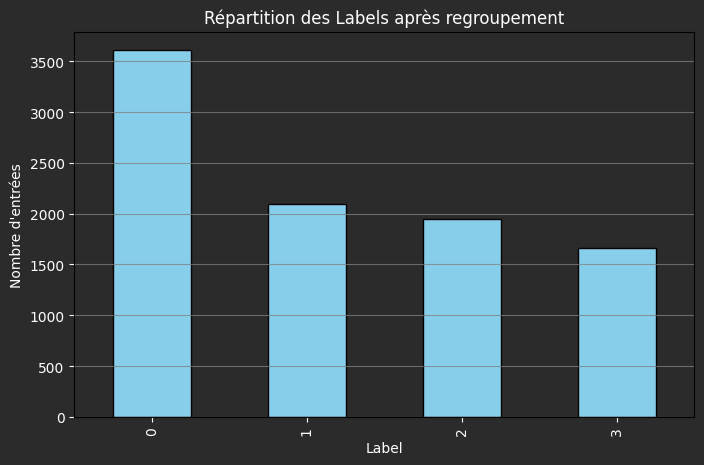

In [40]:
plt.figure(figsize=(8,5), facecolor="#2b2b2b")  # fond gris foncé

ax = train["Labels"].value_counts().sort_index().plot(
    kind="bar",
    color="skyblue",
    edgecolor="black"
)

ax.set_facecolor("#2b2b2b")         
ax.tick_params(colors="white")       
ax.yaxis.label.set_color("white")    
ax.xaxis.label.set_color("white")   
ax.title.set_color("white")         

plt.xlabel("Label")
plt.ylabel("Nombre d'entrées")
plt.title("Répartition des Labels après regroupement")
plt.grid(axis='y', alpha=0.75, color="gray") 
plt.show()

On constate une représentation plus importante des 0 (False) suite au regroupement des classes.

Je décide de conserver les 4 classes pour le moment, le modèle proposera des nuances dont je vérifierai la pertinence.

La proposition pour avoir une classification binaire sera de regrouper 0 et 1 et de regrouper 2 et 3 mais nous garderons un déséquilibre de l'ordre de 5k7 vs 3k6. L'avantage sera d'avoir une sortie binaire pour l'entraînement de mon modèle.

### 4 - Suppression des colonnes de travail

In [41]:
train.head()

,Labels,Text,Text_Tag,len_text,word_text,repeated_letters,count_tag,lang
0,0,say annies list political group support third-...,abortion,82,11,False,1,en
1,1,decline coal start? started natural gas took s...,history energy job-accomplishments,141,24,False,3,en
2,2,"hillary clinton agrees john mccain ""by voting ...",foreign-policy,105,19,False,1,en
3,0,health care reform legislation likely mandate ...,health-care,78,12,False,1,en
4,1,economic turnaround started end term.,economy job,54,10,False,2,en


In [42]:
train = train.drop(["len_text", "word_text", "repeated_letters", "count_tag", "lang"], axis=1)

In [43]:
train.head()

,Labels,Text,Text_Tag
0,0,say annies list political group support third-...,abortion
1,1,decline coal start? started natural gas took s...,history energy job-accomplishments
2,2,"hillary clinton agrees john mccain ""by voting ...",foreign-policy
3,0,health care reform legislation likely mandate ...,health-care
4,1,economic turnaround started end term.,economy job


# 3 - Préparation des jeux de données pour les modèles

## 1 - Création du jeu de validation

In [44]:
text = "Text"
tag = "Text_Tag"
label = "Labels"

X = train[[text, tag]]
y = train[label]

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, y_train.shape)
print("Validation:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (6526, 2) (6526,)
Validation: (1399, 2) (1399,)
Test: (1399, 2) (1399,)


# 4 - Entraînement du modèle Régression Logistique

## 0 - TF-IDF pour Text

#### Création des transformers

In [45]:
text_transformer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

tag_transformer = CountVectorizer(token_pattern=r"(?u)\b\w+\b")

#### Transformation des colonnes

In [46]:
preprocessor = ColumnTransformer(
    transformers=[
        ("text", text_transformer, "Text"),
        ("tags", tag_transformer, "Text_Tag")
    ]
)

#### Création du Pipeline

In [47]:
model_pipeline = Pipeline([
    ("features", preprocessor),
    ("classifier", LogisticRegression(
        solver="lbfgs",
        max_iter=1000,
        class_weight="balanced",
        random_state=42
    ))
])

## 1 - Entraînement

In [48]:
model_pipeline.fit(X_train, y_train)

,steps,"[('features', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('text', ...), ('tags', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 2 - Évaluation

=== Classification Report ===
                precision    recall  f1-score   support

         False       0.47      0.38      0.42       541
Partially True       0.27      0.28      0.27       315
   Mostly True       0.26      0.28      0.27       293
          True       0.25      0.33      0.28       250

      accuracy                           0.33      1399
     macro avg       0.31      0.32      0.31      1399
  weighted avg       0.34      0.33      0.33      1399



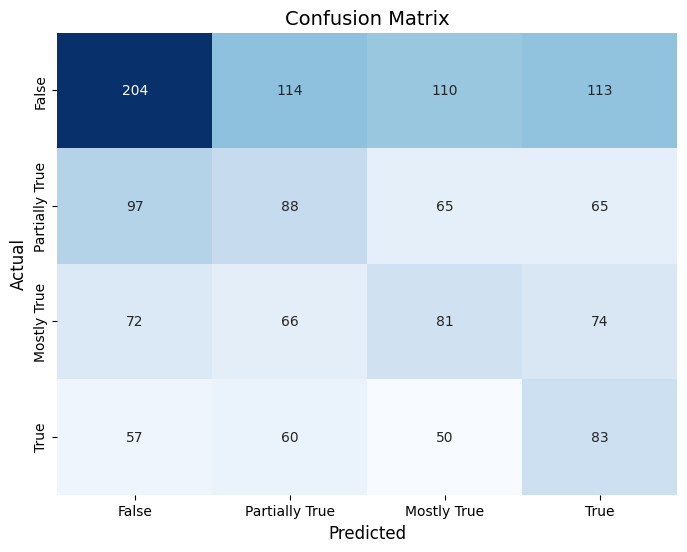

In [49]:
y_pred = model_pipeline.predict(X_val)

print("=== Classification Report ===")
print(classification_report(y_val, y_pred, target_names=["False", "Partially True", "Mostly True", "True"]))

# --- Matrice de confusion ---
cm = confusion_matrix(y_val, y_pred)
labels = ["False", "Partially True", "Mostly True", "True"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.show()

                precision    recall  f1-score      support
False            0.474419  0.377079  0.420185   541.000000
Partially True   0.268293  0.279365  0.273717   315.000000
Mostly True      0.264706  0.276451  0.270451   293.000000
True             0.247761  0.332000  0.283761   250.000000
accuracy         0.325947  0.325947  0.325947     0.325947
macro avg        0.313795  0.316224  0.312028  1399.000000
weighted avg     0.343582  0.325947  0.331468  1399.000000


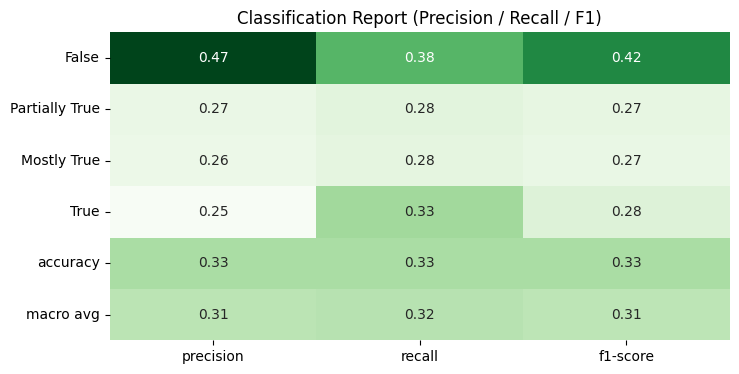

In [50]:
report = classification_report(y_val, y_pred, target_names=labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# affichage stylisé
print(df_report)

# heatmap des scores
plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="Greens", cbar=False, fmt=".2f")
plt.title("Classification Report (Precision / Recall / F1)")
plt.show()

# 5 - Entraînement du modèle Random Forest

## 1 - Pipeline

In [51]:
model_pipeline2 = Pipeline([
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    ))
])

## 2 - Entraînement

In [52]:
print(X_train.shape)
print(len(y_train))


(6526, 2)
6526


In [53]:
model_pipeline2.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('text', ...), ('tags', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 3 - Évaluation

=== Classification Report ===
                precision    recall  f1-score   support

         False       0.42      0.83      0.55       541
Partially True       0.28      0.09      0.14       315
   Mostly True       0.33      0.16      0.21       293
          True       0.36      0.12      0.18       250

      accuracy                           0.40      1399
     macro avg       0.35      0.30      0.27      1399
  weighted avg       0.36      0.40      0.32      1399



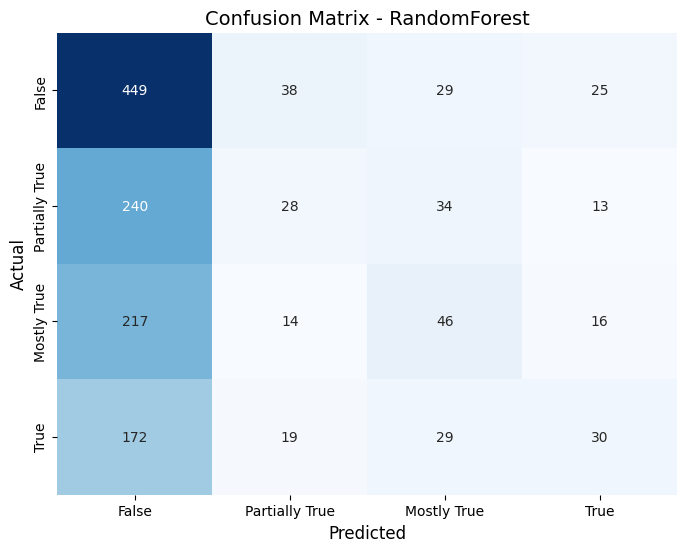

In [54]:
y_pred = model_pipeline2.predict(X_val)

# Rapport
print("=== Classification Report ===")
print(classification_report(y_val, y_pred, target_names=["False", "Partially True", "Mostly True", "True"]))

# --- Matrice de confusion graphique ---
cm = confusion_matrix(y_val, y_pred)
labels = ["False", "Partially True", "Mostly True", "True"]

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels, cbar=False)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix - RandomForest", fontsize=14)
plt.show()

# 6 - LSTM

## 1 - Préparation des données

In [55]:
X_train_text = (X_train["Text"].astype(str) + " " + X_train["Text_Tag"].astype(str)).tolist()
X_val_text = (X_val["Text"].astype(str) + " " + X_val["Text_Tag"].astype(str)).tolist()
X_test_text = (X_test["Text"].astype(str) + " " + X_test["Text_Tag"].astype(str)).tolist()


In [56]:
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, class_weights))
print(class_weight_dict)

{np.int64(0): np.float64(0.645627225959636), np.int64(1): np.float64(1.111376021798365), np.int64(2): np.float64(1.1952380952380952), np.int64(3): np.float64(1.3992281303602059)}


In [57]:
max_words = 5000
max_len = 100 
embedding_dim = 100
lstm_units = 32

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train_text), maxlen=max_len)
X_val_seq   = pad_sequences(tokenizer.texts_to_sequences(X_val_text), maxlen=max_len)
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test_text), maxlen=max_len)




## 2 - Création du modèle

In [58]:
model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim),
    Bidirectional(LSTM(lstm_units, dropout=0.3, recurrent_dropout=0.3)),
    Dense(4, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## 4 - Entraînement

In [59]:
history = model.fit(
    X_train_seq, np.array(y_train),
    validation_data=(X_val_seq, np.array(y_val)),
    epochs=6,
    batch_size=32,
    class_weight=class_weight_dict
)

Epoch 1/6
204/204 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.2409 - loss: 1.3882 - val_accuracy: 0.3867 - val_loss: 1.3761
Epoch 2/6
204/204 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - accuracy: 0.2481 - loss: 1.3877 - val_accuracy: 0.2452 - val_loss: 1.3902
Epoch 3/6
204/204 ━━━━━━━━━━━━━━━━━━━━ 13s 61ms/step - accuracy: 0.2613 - loss: 1.3866 - val_accuracy: 0.2888 - val_loss: 1.3832
Epoch 4/6
204/204 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.2499 - loss: 1.3867 - val_accuracy: 0.2688 - val_loss: 1.3806
Epoch 5/6
204/204 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.2508 - loss: 1.3860 - val_accuracy: 0.2888 - val_loss: 1.3786
Epoch 6/6
204/204 ━━━━━━━━━━━━━━━━━━━━ 13s 64ms/step - accuracy: 0.2763 - loss: 1.3854 - val_accuracy: 0.2237 - val_loss: 1.3891


## 5 - Évaluation

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
=== Classification Report ===
                precision    recall  f1-score   support

         False       0.00      0.00      0.00       541
Partially True       0.24      0.64      0.35       315
   Mostly True       0.00      0.00      0.00       293
          True       0.19      0.44      0.27       250

      accuracy                           0.22      1399
     macro avg       0.11      0.27      0.16      1399
  weighted avg       0.09      0.22      0.13      1399



/Users/macbook/Dev/ML/ML - Jour 4/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/macbook/Dev/ML/ML - Jour 4/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/macbook/Dev/ML/ML - Jour 4/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

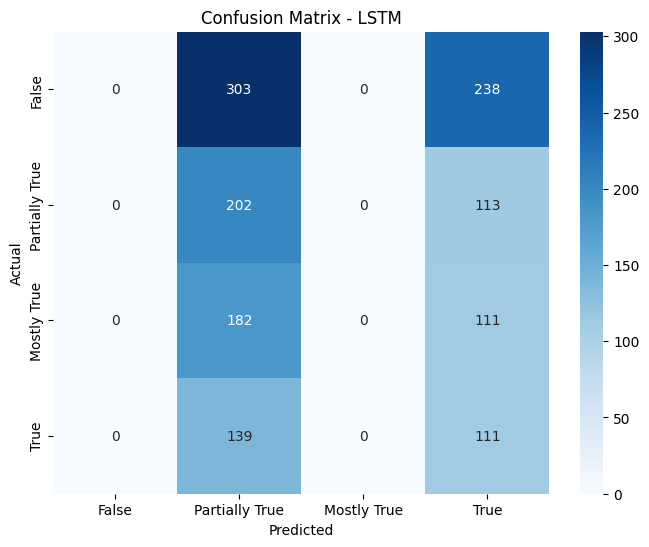

In [60]:
# Prédictions
y_pred_prob = model.predict(X_val_seq)
y_pred = np.argmax(y_pred_prob, axis=1)

labels_names = ["False", "Partially True", "Mostly True", "True"]
print("=== Classification Report ===")
print(classification_report(y_val, y_pred, target_names=labels_names))

# Matrice de confusion graphique
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels_names, yticklabels=labels_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - LSTM")
plt.show()